<a href="https://colab.research.google.com/github/Motaz-Saidani/Convolutional-Neural-Network-Crack-Detection-with-Transfer-Learning-ResNet50/blob/main/Crack_Detection_with_Transfer_Learning_(ResNet50).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Crack Detection with Transfer Learning (ResNet50)
Crack detection has vital importance for structural health monitoring and inspection. In this notebook, I will build an image classifier using specific blocks from the ResNet50 layers and evaluate its performance using only one epoch. Images with cracks are denoted as positive and images without cracks as negative.

In [1]:
import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pylab as plt
from matplotlib.pyplot import imshow

import tensorflow as tf
from keras import layers, Model
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.applications.resnet import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

<a>

## Downloading Data

In [2]:
!gdown --id 1ZZFrPVMjBpBEDlV_5lTMaHpiU4SOubul

Downloading...
From: https://drive.google.com/uc?id=1ZZFrPVMjBpBEDlV_5lTMaHpiU4SOubul
To: /content/concrete_data.zip
100% 246M/246M [00:03<00:00, 79.7MB/s]


In [3]:
!unzip concrete_data.zip &> /dev/null

<a>

## Constructing ImageDataGenerator Instances


In [4]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
    )

In [5]:
#defining global constants
num_classes = 2

image_resize = 224

batch_size_training = 100
batch_size_validation = 100

### Training set

In [6]:
train_generator = data_generator.flow_from_directory(
    'concrete_data/train',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical'
    )

train_generator.class_indices

Found 30000 images belonging to 2 classes.


{'negative': 0, 'positive': 1}

In [7]:
#checking if the training set is balanced
pd.Series(train_generator.labels).value_counts()

1    15000
0    15000
dtype: int64

### Validation set


In [8]:
validation_generator = data_generator.flow_from_directory(
    'concrete_data/valid',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

Found 9500 images belonging to 2 classes.


<a>

## Displaying and Analyzing  the Images
####Images without cracks

In [9]:
train_paths = train_generator.filepaths
train_paths[0:2]

['concrete_data/train/negative/00001.jpg',
 'concrete_data/train/negative/00002.jpg']

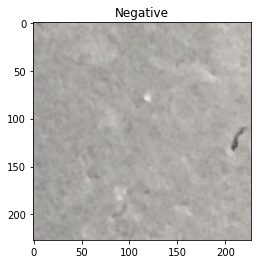

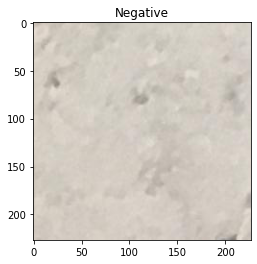

In [10]:
counter = 0
for i in train_paths: 
  if "negative" in i:
      img=Image.open(i)
      plt.imshow(img)
      plt.title("Negative")
      plt.show()
      counter += 1
      if counter == 2:
        break #breaking after displaying two images

####Images with cracks

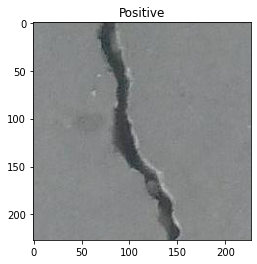

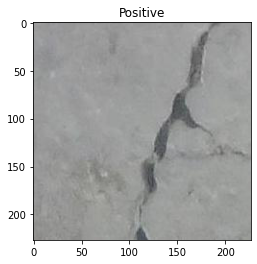

In [11]:
counter = 0
for i in train_paths: 
  if "positive" in i:
      img=Image.open(i)
      plt.imshow(img)
      plt.title("Positive")
      plt.show()
      counter += 1
      if counter == 2:
        break #breaking after displaying two images

<a>

## Building & Compiling the Model


In [12]:
pre_trained_model = ResNet50(input_shape = (image_resize, image_resize, 3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [13]:
last_layer = pre_trained_model.get_layer('conv5_block1_1_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 512)


In [14]:
# Flattening the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(2, activation='softmax')(x)           

model = Model(pre_trained_model.input, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [15]:
model.compile(optimizer = RMSprop(learning_rate=0.0001, momentum=0.9), 
              loss = "binary_crossentropy", 
              metrics = ['acc'])

<a>

## Fitting the Model

In [16]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 1

In [17]:
from keras.callbacks import Callback

class Histories(Callback):
    def on_train_begin(self,logs={}):
        self.losses = []
        self.accuracies = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('acc'))
histories = Histories()

fit_history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,
    callbacks=[histories]
)

300/300 [==============================] - 227s 712ms/step - loss: 0.0199 - acc: 0.9940 - val_loss: 0.0093 - val_acc: 0.9964


<a>

## Visualising Loss/Accuracy at each iteration

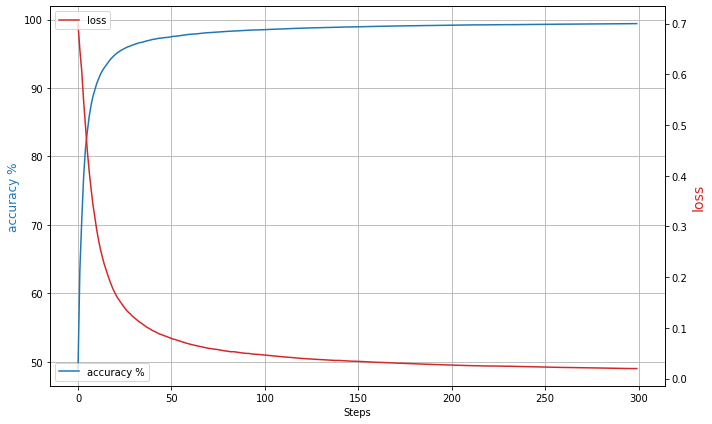

In [18]:
data1 = [i * 100 for i in histories.accuracies]
data2 = histories.losses

fig, ax1 = plt.subplots(figsize = (10,6))
color = 'tab:blue'
ax1.set_xlabel('Steps')
ax1.set_ylabel('accuracy %', color=color, size=12)
ax1.plot(data1, color=color)
ax1.grid()
ax1.legend(['accuracy %'],loc='lower left')

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('loss', color=color, size=14)  
ax2.plot(data2, color=color)
ax2.legend(['loss'],loc='upper left')

fig.tight_layout() 
plt.show()

<a>

## Saving the Model

In [19]:
model.save('classifier_ResNet50_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [20]:
ResNet50_model = load_model('classifier_ResNet50_model.h5')

<a>

## Generating Testing Set


In [21]:
test_generator = data_generator.flow_from_directory(
    'concrete_data/test',
    target_size=(image_resize, image_resize),
    class_mode='categorical', shuffle=False,)

test_generator.class_indices

Found 500 images belonging to 2 classes.


{'negative': 0, 'positive': 1}

<a>

## Evaluating the Model


In [22]:
ResNet50_evaluation = ResNet50_model.evaluate(test_generator)

print("Test Accuracy :", str(round(ResNet50_evaluation[1]*100, 2)),'%')

16/16 [==============================] - 5s 216ms/step - loss: 0.0011 - acc: 1.0000
Test Accuracy : 100.0 %


## Visualizing CNN layers

In [23]:
def display_activation(activations, col_size, row_size, act_index): 

    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='Blues')
            activation_index += 1

### Original Image

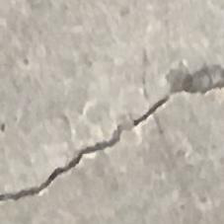

In [24]:
img_index = 454

img = Image.open(test_generator.filepaths[img_index])
img = img.resize((224, 224), Image.ANTIALIAS)
img_np = np.expand_dims(img, axis=0)

img

###Displaying some filters from the 10th layer

In [25]:
layer_outputs = [layer.output for layer in ResNet50_model.layers]
activation_model = Model(inputs=ResNet50_model.input, outputs=layer_outputs)
activations = activation_model.predict(img_np)

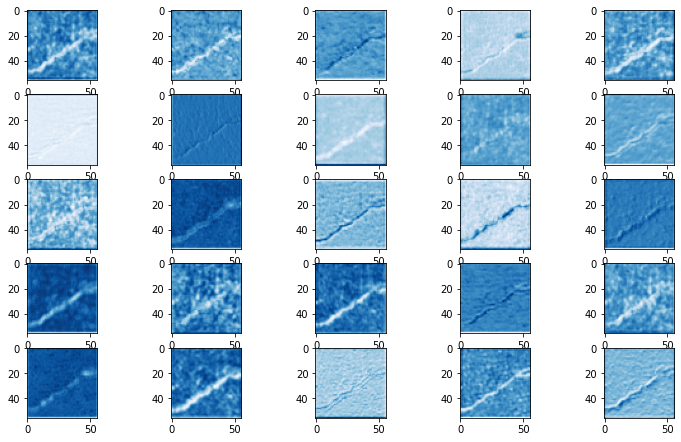

In [26]:
display_activation(activations, 5, 5, 10)

###Filters from the 110th layer

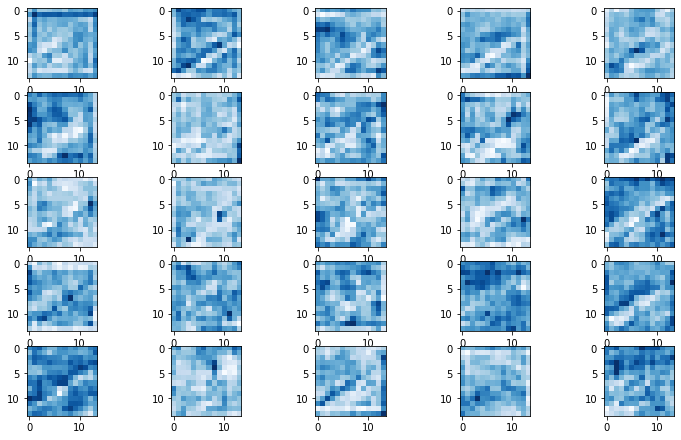

In [27]:
display_activation(activations, 5, 5, 110)